# Explore Bottle File Data from CCHDO

In this notebook we will plot data from a bottle file, collected on a repeat hydrographic section part of the GO-SHIP repeat hydrographic program.

All hydrographic data part of this progam are publicly avaiable and are archived at [CCHDO](https://cchdo.ucsd.edu/). The section analyzed here (P18) is a meridonal transect in the eastern Pacific roughly along the 103$^o$W meridian. Section data is available at https://cchdo.ucsd.edu/cruise/33RO20161119. The netCDF file for the bottle data can be downloaded [here](https://cchdo.ucsd.edu/data/38327/33RO20161119_nc_hyd.zip).

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import gsw
%matplotlib inline

plt.rcParams["font.size"] = 16
plt.rcParams["figure.facecolor"] = 'white'
import warnings
warnings.filterwarnings('ignore')

datapath = './data/'

In [2]:
# Load netCDF file locally as xarray Dataset

dd = xr.load_dataset(datapath+'p18_btl.nc')
dd

<xarray.Dataset> Size: 3MB
Dimensions:                            (N_PROF: 213, N_LEVELS: 24)
Coordinates:
    expocode                           (N_PROF) object 2kB '33RO20161119' ......
    station                            (N_PROF) object 2kB '1' '2' ... '212'
    cast                               (N_PROF) int32 852B 3 2 1 1 1 ... 1 1 1 1
    sample                             (N_PROF, N_LEVELS) object 41kB '24' .....
    time                               (N_PROF) datetime64[ns] 2kB 2016-11-24...
    latitude                           (N_PROF) float64 2kB 22.69 ... -68.07
    longitude                          (N_PROF) float64 2kB -110.0 ... -95.0
    pressure                           (N_PROF, N_LEVELS) float64 41kB 3.1 .....
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/86)
    section_id                         (N_PROF) object 2kB 'P18' 'P18' ... 'P18'
    bottle_number                      (N_PROF, N_LEVELS) object 41kB '11122'...
    bottle_number_qc                   (N_PROF, N_LEVELS) float32 20kB 2.0 .....
    btm_depth                          (N_PROF) float64 2kB 2.619e+03 ... 4.4...
    ctd_temperature                    (N_PROF, N_LEVELS) float64 41kB 27.88 ...
    ctd_salinity                       (N_PROF, N_LEVELS) float64 41kB 34.53 ...
    ...                                 ...
    n2_argon_ratio_unstripped_error    (N_PROF, N_LEVELS) float64 41kB nan .....
    d15n_n2                            (N_PROF, N_LEVELS) float64 41kB nan .....
    d15n_n2_qc                         (N_PROF, N_LEVELS) float32 20kB nan .....
    d15n_n2_error                      (N_PROF, N_LEVELS) float64 41kB nan .....
    profile_type                       (N_PROF) object 2kB 'B' 'B' ... 'B' 'B'
    geometry_container                 float64 8B nan
Attributes:
    Conventions:               CF-1.8 CCHDO-1.0
    cchdo_software_version:    hydro 1.0.2.8
    cchdo_parameters_version:  params 2024.4.0
    comments:                  BOTTLE,20230606CCHSIOCBG\n Merged parameters: ...
    featureType:               profile

In [3]:
# List the variables in this bottle file
all_vars = [i for i in dd.data_vars] 
print(all_vars)

['section_id', 'bottle_number', 'bottle_number_qc', 'btm_depth', 'ctd_temperature', 'ctd_salinity', 'ctd_salinity_qc', 'bottle_salinity', 'bottle_salinity_qc', 'ctd_oxygen', 'ctd_oxygen_qc', 'oxygen', 'oxygen_qc', 'silicate', 'silicate_qc', 'nitrate', 'nitrate_qc', 'nitrite', 'nitrite_qc', 'phosphate', 'phosphate_qc', 'cfc_11', 'cfc_11_qc', 'cfc_12', 'cfc_12_qc', 'sulfur_hexifluoride', 'sulfur_hexifluoride_qc', 'total_carbon', 'total_carbon_qc', 'total_alkalinity', 'total_alkalinity_qc', 'ph_sws', 'ph_sws_qc', 'ph_temperature', 'dissolved_organic_carbon', 'dissolved_organic_carbon_qc', 'del_carbon_13_dic', 'del_carbon_13_dic_qc', 'del_carbon_14_dic', 'del_carbon_14_dic_qc', 'del_carbon_14_dic_error', 'particulate_organic_carbon', 'particulate_organic_carbon_qc', 'particulate_organic_nitrogen', 'particulate_organic_nitrogen_qc', 'total_dissolved_phosphorus', 'total_dissolved_phosphorus_qc', 'total_dissolved_nitrogen', 'total_dissolved_nitrogen_qc', 'carbon_tetrachloride', 'carbon_tetrac

In [4]:
exclude_vars = ['bottle_number']  # exclude these variables

# get a list of variables that we might be interested in-
# Filter remove one dimensional variables, QC flags and error variables

vars_of_interest = [i for i in all_vars if '_qc' not in i and '_error' not in i
                    and i not in exclude_vars 
                    and len(dd[i].dims)==2]
print(vars_of_interest)

['ctd_temperature', 'ctd_salinity', 'bottle_salinity', 'ctd_oxygen', 'oxygen', 'silicate', 'nitrate', 'nitrite', 'phosphate', 'cfc_11', 'cfc_12', 'sulfur_hexifluoride', 'total_carbon', 'total_alkalinity', 'ph_sws', 'ph_temperature', 'dissolved_organic_carbon', 'del_carbon_13_dic', 'del_carbon_14_dic', 'particulate_organic_carbon', 'particulate_organic_nitrogen', 'total_dissolved_phosphorus', 'total_dissolved_nitrogen', 'carbon_tetrachloride', 'nitrous_oxide', 'nitrous_oxide_l_alt_1', 'dissolved_organic_carbon_14', 'dissolved_organic_carbon_13', 'd15n_no3', 'd15n_n2o', 'd15n_alpha_n2o', 'd15n_nitrite_nitrate', 'd18o_nitrite_nitrate', 'd18o_nitrate', 'd18o_nitrust_oxide', 'n2_argon_ratio', 'n2_argon_ratio_unstripped', 'd15n_n2']


In [5]:
# Calculate Depth as a function of pressure, latitude
depth = gsw.z_from_p(dd.pressure,
                     dd.latitude,)

### We can plot some of these variables of interest in a subplot together
1. Lets plot 16 variables in a 4x4 grid
2. Select a profile number **profile_num** to plot these 25 variables from
2. Select some plotting colors
3. Loop through these and plot

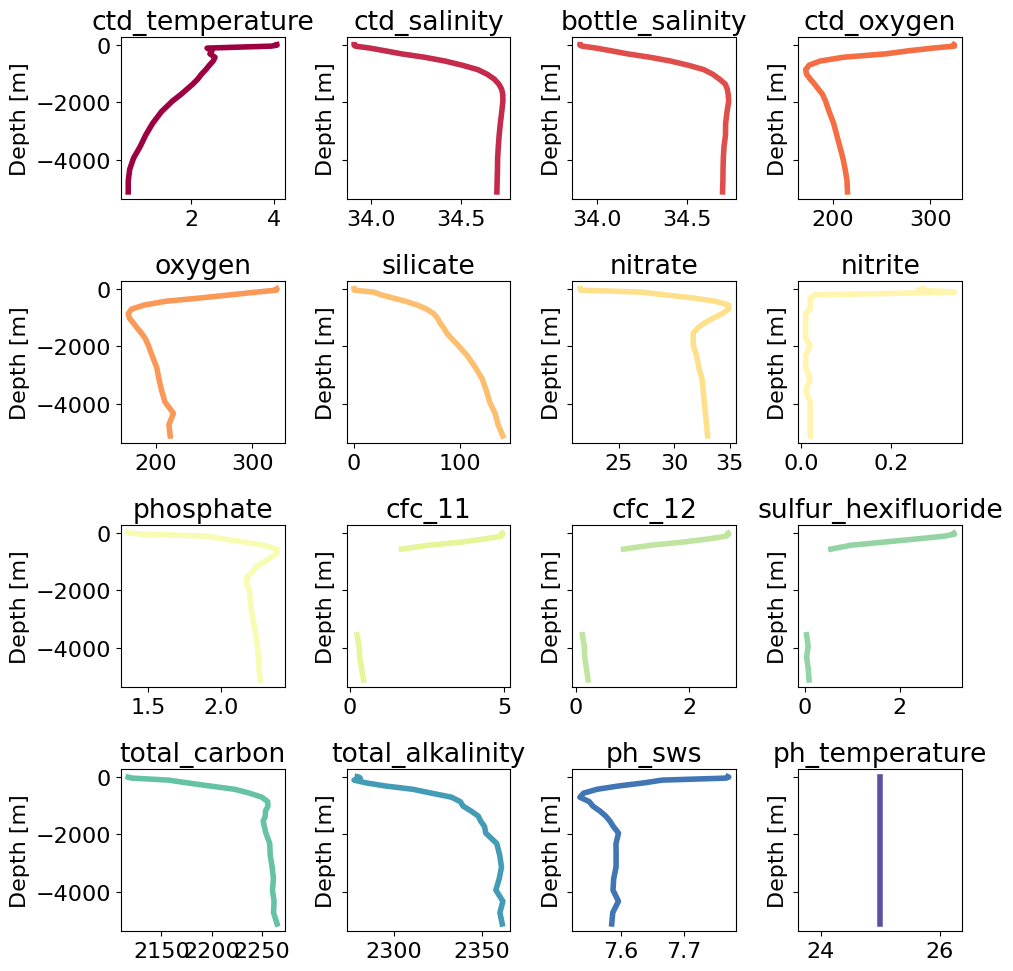

In [6]:
num_plots = 16  # number of variables to plot
profile_num = 190 # select profile number to plot 

# Choose the colormap
cmap = mpl.colormaps['Spectral']
# Get evenly spaced colors from the colormap
colors = [cmap(i) for i in np.linspace(0, 256, num_plots, dtype=int)]

num_rows = int(np.sqrt(num_plots))
num_cols = int(np.sqrt(num_plots))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10),sharey=True)
# Loop through variables and plot in each subplot
for i, var in enumerate(vars_of_interest[:16]):
    # Calculate subplot index
    row = i // num_rows
    col = i % num_cols
    
    # Plot variable on the corresponding subplot
    axs[row, col].plot(dd[var][profile_num],depth[profile_num], 
                       label=var,linewidth='4',color=colors[i])
    axs[row, col].set_title(var)
    axs[row, col].set_ylabel('Depth [m]')

plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot

#### Next, we can calculate Absolute Salinity (SA) and Conservative Temperature ($\Theta$) and Potential Density ($\sigma_0$)using the GSW Toolbox

In [7]:
dd['SA'] = gsw.SA_from_SP(dd.ctd_salinity, dd.pressure, dd.longitude, dd.latitude)
dd['CT'] = gsw.CT_from_t(dd.SA,dd.ctd_temperature, dd.pressure)
dd['sigma_0'] = gsw.sigma0(dd.SA,dd.CT)

#### Now we can plot a T-S diagram using this information for all profiles along the section.
We will also contour potential density, which is useful to identify water masses and water-mass transformation

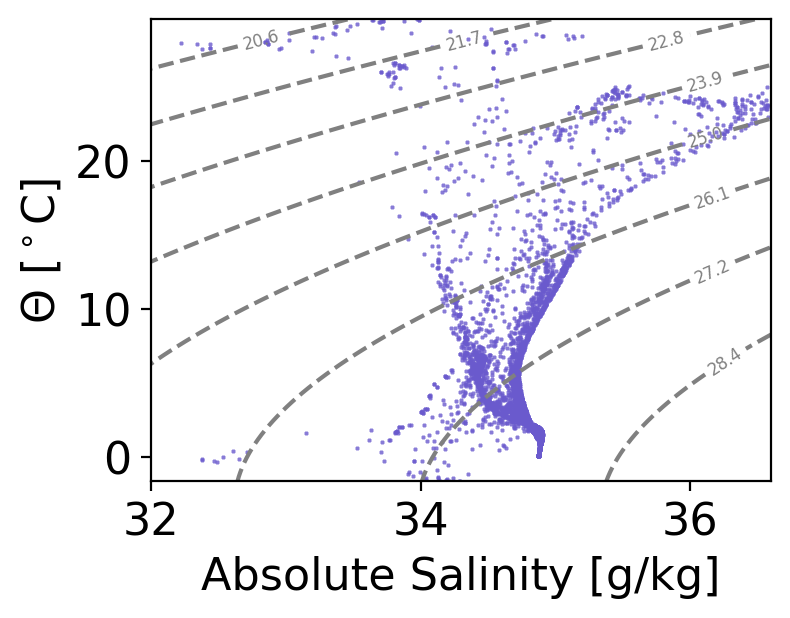

In [8]:
plt.figure(figsize=(4,3),dpi=200)

# Create a grid of SA and CT values using meshgrid
SA_vals = np.linspace(dd.SA.min().item(), dd.SA.max().item(), 100)
CT_vals = np.linspace(dd.CT.min().item(), dd.CT.max().item(), 100)
SA_grid, CT_grid = np.meshgrid(SA_vals, CT_vals)

# Calculate potential density at each point on the grid
p_density = gsw.sigma0(SA_grid, CT_grid)  # Assuming reference pressure of 0 dbar
# Scatter plot of Absolute Salinity vs. Conservative Temperature
plt.plot(dd.SA, dd.CT, 
         color='slateblue',
         marker='+',
         markersize=1.2,
         alpha=0.8,
         linestyle='')

# Add potential density contours
density_levels = np.linspace(min(p_density.flatten()), max(p_density.flatten()), 10)  # Choose density levels
CS = plt.contour(SA_grid, CT_grid, p_density, 
                 levels=density_levels, 
                 colors='gray', 
                 linestyles='dashed')
plt.clabel(CS, inline=True, fontsize=6, fmt='%.1f')

# Label axes
plt.xlabel('Absolute Salinity [g/kg]')
plt.ylabel(r'$\Theta$ [$^\circ$C]')

# Set axis limit
plt.xlim(32,36.6)
plt.show()